## Подготовка данных

### Импорт библиотек

In [189]:
import os
import sys
from pathlib import Path

# Добавляем путь на уровень выше
sys.path.append(str(Path(os.getcwd()).resolve().parent))

from utils.features import *
from utils.load_data import load_all_data
from utils.feature_engineering import add_features
from utils.graph_features import GraphClusterProcessor

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter

import numpy as np
import networkx as nx
from node2vec import Node2Vec

import time
from tqdm import tqdm
from sklearn.cluster import KMeans

### Загрузка данных

In [190]:
data_dir = Path('../data/PEMS04')
metadata, data, adj = load_all_data(data_dir)
data = data[:2016]
data = data.copy()

data[:, :, 1] = data[:, :, 1] * 288
data[:, :, 2] = data[:, :, 2] * 7

### Lag

In [191]:
def lagged_feature(data, lags=[1,2,3]):
    """Добавляет лаггированные признаки для данных."""
    data_lagged = []
    for lag in lags:
        lagged_data = np.roll(data, shift=lag, axis=0)  # Сдвигаем данные на заданное количество шагов
        lagged_data[:lag] = 0  # Заполняем пропуски нулями
        data_lagged.append(lagged_data)
    
    # Объединяем оригинальные данные с лагами
    data_lagged = np.concatenate(data_lagged, axis=-1)
    
    return data_lagged

lagged_data = lagged_feature(data[:, :, :1], lags=[1,2,3,4,5,6,7,8,9,10,11,12])

data_expanded = np.concatenate([data, lagged_data], axis=-1)  # Форма: (2016, 325, 3 + 1)

# Проверка результата
print("Исходные данные (временные ряды):", data.shape)
print("Эмбеддинги узлов:", lagged_data.shape)
print("Объединённые данные:", data_expanded.shape)


Исходные данные (временные ряды): (2016, 307, 3)
Эмбеддинги узлов: (2016, 307, 12)
Объединённые данные: (2016, 307, 15)


### Derivative

In [39]:
def derivative_feature(data, n=1):
    """Вычисляет производную с сохранением размерности."""
    derivative = np.diff(data, axis=0, n=n)  # Вычисляем производную
    # Дополняем результат нулями в начале, чтобы сохранить размерность
    if n > 0:
        padding = np.zeros((n,) + data.shape[1:], dtype=data.dtype)
        derivative = np.concatenate([padding, derivative], axis=0)
    return derivative


first_derivative_data = derivative_feature(data_expanded[:, :, 3:], n=1)
second_derivative_data = derivative_feature(data_expanded[:, :, 3:], n=2)

data_expanded = np.concatenate([data_expanded, first_derivative_data, second_derivative_data], axis=-1)  # Форма: (2016, 325, 3 + 1)

# Проверка результата
print("Исходные данные (временные ряды):", data.shape)
print("Первая производная узлов:", first_derivative_data.shape)
print("Вторая производная узлов:", second_derivative_data.shape)
print("Объединённые данные:", data_expanded.shape)

Исходные данные (временные ряды): (2016, 358, 3)
Первая производная узлов: (2016, 358, 12)
Вторая производная узлов: (2016, 358, 12)
Объединённые данные: (2016, 358, 39)


### GraphClusterProcessor


In [178]:
processor = GraphClusterProcessor(adj, data)
processor.elbow_method(metric='PageRank', max_clusters=15)

labels = KMeans(n_clusters=3, random_state=42).fit_predict(
    np.array(list(nx.betweenness_centrality(nx.from_numpy_array(adj)).values())).reshape(-1, 1)
)
processor.plot_group_average_speeds(labels, n_clusters=3)

In [179]:
data_expanded = processor.cluster_and_add_channel(metric='PageRank', n_clusters=3, one_hot=False, )

### Other Features


In [ ]:
# Определение функций
feature_functions = {
    # 'minute': minute_index_feature,
    # 'weekday': weekday_index_feature,
    # 'fft': fft_denoise_feature,
    # 'mean': mean_feature,
    # 'median': median_feature,
    # 'std': std_feature,
    # 'min': min_feature,
    # 'max': max_feature,
    # 'kurtosis': kurtosis_feature,
    # 'skew': skew_feature,
    # 'quantile': quantile_feature,
    # 'rolling_mean': rolling_mean_feature,
    # 'rolling_std': rolling_std_feature,
    # 'rolling_min': rolling_min_feature,
    # 'rolling_max': rolling_max_feature,
    # 'derivative': derivative_feature,
}

graph_feature_functions = {
    # 'degree': degree_feature,
    # 'node_index': node_indices_feature,
    # 'degree_centrality': degree_centrality_feature,
    # 'closeness_centrality': closeness_centrality_feature,
    # 'betweenness_centrality': betweenness_centrality_feature,
    'clustering_coefficient': clustering_coefficient_feature,
}

# Добавление фичей для train
data_expanded = add_features(
    data,
    feature_list=list(feature_functions.keys()),
    feature_functions=feature_functions,
    graph_feature_functions=graph_feature_functions,
    index=None,
    adj_matrix=adj
)

data_expanded.shape

### Node Emb

In [ ]:
node_indices = np.array([i for i in range(data.shape[1])])
node_indices_expanded = np.expand_dims(node_indices, axis=0)  # Форма: (1, 325,)
node_indices_expanded = np.expand_dims(node_indices_expanded, axis=-1)  # Форма: (1, 325, 1)
node_indices_expanded = np.repeat(node_indices_expanded, data.shape[0], axis=0)  # Форма: (2016, 325, 1)

# Объединение с временными рядами по последней оси
data_expanded = np.concatenate([data, node_indices_expanded], axis=-1)  # Форма: (2016, 325, 3 + 1)

# Проверка результата
print("Исходные данные (временные ряды):", data.shape)
print("Эмбеддинги узлов:", node_indices.shape)
print("Объединённые данные:", data_expanded.shape)

### Node2vec embeddings

In [ ]:
np.fill_diagonal(adj, 0)
G = nx.from_numpy_array(adj)
node2vec = Node2Vec(G, dimensions=64, walk_length=30, num_walks=400, p=1, q=1, workers=12)
model = node2vec.fit(window=10, min_count=1, batch_words=4)
node_embeddings = np.array([model.wv[str(node)] for node in G.nodes()])

In [ ]:
node_embeddings_expanded = np.expand_dims(node_embeddings, axis=0)  # Форма: (1, 325, 64)
node_embeddings_expanded = np.repeat(node_embeddings_expanded, data.shape[0], axis=0)  # Форма: (2016, 325, 64)

# 4. Объединение с временными рядами по последней оси
data_expanded = np.concatenate([data, node_embeddings_expanded], axis=-1)  # Форма: (2016, 325, 3 + 64)

# 5. Проверка результата
print("Исходные данные (временные ряды):", data.shape)
print("Эмбеддинги узлов:", node_embeddings.shape)
print("Объединённые данные:", data_expanded.shape)

### Position Encoding (PE)

In [ ]:
def positional_encoding(pos, d_model):
    position = np.arange(pos)[:, np.newaxis]
    div_term = np.exp(np.arange(0, d_model, 2) * -(np.log(10000.0) / d_model))
    pe = np.zeros((pos, d_model))
    pe[:, 0::2] = np.sin(position * div_term)
    pe[:, 1::2] = np.cos(position * div_term)
    return pe

# Пример для 325 узлов
num_nodes = data.shape[1]
d_model = 16
pe = positional_encoding(num_nodes, d_model)  # Форма: (325, 64)

# Расширение до (batch_size, 325, 64)
pe = positional_encoding(num_nodes, d_model).astype(np.float32)  # Используйте float32
pe_expanded = np.expand_dims(pe, axis=0)  # Форма: (1, 325, 64)
pe_expanded = np.repeat(pe_expanded, data.shape[0], axis=0)  # Форма: (2016, 325, 64)
pe_expanded = torch.tensor(pe_expanded, dtype=torch.float32)     # Для тензоров

data_expanded = np.concatenate([data, pe_expanded], axis=-1)  # Форма: (2016, 325, 3 + 64)

# 5. Проверка результата
print("Исходные данные (временные ряды):", data.shape)
print("Эмбеддинги узлов:", pe_expanded.shape)
print("Объединённые данные:", data_expanded.shape)

### Разделение данных и создание Dataloader

In [192]:
# Данные и параметры
L, N, C = data_expanded.shape  # [2016, 325, C]
batch_size = 16
train_ratio = 0.7
val_ratio = 0.1
test_ratio = 0.2
seq_len = 12  # Количество временных шагов на вход
pred_len = 12  # Количество временных шагов для предсказания

# Индексы каналов для нормализации
normalize = True

channels_to_normalize = [0] + list(i for i in range(3, C))

# Проверка корректности разделения данных
assert train_ratio + val_ratio + test_ratio == 1.0, "Сумма долей train, val и test должна быть равна 1.0"

# Разделение данных на train, val и test
num_samples = data_expanded.shape[0]  # Количество временных шагов (L)
train_size = int(num_samples * train_ratio)
val_size = int(num_samples * val_ratio)
test_size = num_samples - train_size - val_size

train_data = data_expanded[:train_size, :, :]  # [train_size, N, C]
val_data = data_expanded[train_size:train_size + val_size, :, :]  # [val_size, N, C]
test_data = data_expanded[train_size + val_size:, :, :]  # [test_size, N, C]

# Нормализация данных
if normalize:
    assert all(0 <= ch < C for ch in channels_to_normalize), "Индексы каналов выходят за пределы допустимого диапазона"
    channel_max = train_data[:, :, channels_to_normalize].max(axis=(0, 1), keepdims=True)  # Форма [1, 1, len(channels_to_normalize)]
    channel_max[channel_max == 0] = 1.0
    train_data[:, :, channels_to_normalize] = train_data[:, :, channels_to_normalize] / channel_max
    val_data[:, :, channels_to_normalize] = val_data[:, :, channels_to_normalize] / channel_max
    test_data[:, :, channels_to_normalize] = test_data[:, :, channels_to_normalize] / channel_max

# Создание кастомного Dataset
class TrafficDataset(Dataset):
    def __init__(self, data, seq_len, pred_len):
        super().__init__()
        self.data = data  # Форма [L, N, C]
        self.seq_len = seq_len
        self.pred_len = pred_len

    def __len__(self):
        # Количество возможных последовательностей
        return self.data.shape[0] - self.seq_len - self.pred_len + 1

    def __getitem__(self, idx):
        # Извлекаем последовательность входных данных
        x = self.data[idx:idx + self.seq_len, :, :]  # Форма [seq_len, N, C]
        # Извлекаем целевую последовательность
        y = self.data[idx + self.seq_len:idx + self.seq_len + self.pred_len, :, 0]  # Форма [pred_len, N, C]
        return x, y
    
# Преобразование данных в тензоры с dtype=torch.float32
train_data = torch.tensor(train_data, dtype=torch.float32)
val_data = torch.tensor(val_data, dtype=torch.float32)
test_data = torch.tensor(test_data, dtype=torch.float32)

# Создание DataLoader
train_dataset = TrafficDataset(train_data, seq_len, pred_len)
val_dataset = TrafficDataset(val_data, seq_len, pred_len)
test_dataset = TrafficDataset(test_data, seq_len, pred_len)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [193]:
for x, y in train_loader:
    print(f"Shape of x (input data):    {x.shape}")  # [B, L, N, C]
    print(f"Shape of y (target data):   {y.shape}")  # [B, L, N]

    # Проверка первых двух сенсоров и временных шагов
    print("\nFirst two sensors and time steps in x:")
    print(x[0, :2, :2, :])  # Первый батч, первые два временных шага, первые два сенсора, все каналы

    print("\nFirst two sensors and time steps in y:")
    print(y[0, :2, :2])  # Первый батч, первые два временных шага, первые два сенсора

    # Проверка типов данных для всех каналов
    print("\nData types for each channel in x:")
    for channel in range(x.shape[3]):  # Проходим по всем каналам
        print(f"Channel {channel} dtype: {x[0, 0, 0, channel].dtype}, device: {x[0, 0, 0, channel].device}")

    # Остановка выполнения для ручной проверки
    break

Shape of x (input data):    torch.Size([16, 12, 307, 15])
Shape of y (target data):   torch.Size([16, 12, 307])

First two sensors and time steps in x:
tensor([[[2.5200e-01, 2.3600e+02, 3.0000e+00, 3.1585e-01, 2.5542e-01,
          3.1357e-01, 3.1243e-01, 2.4629e-01, 3.1585e-01, 3.0673e-01,
          2.9532e-01, 4.0365e-01, 3.6602e-01, 3.3979e-01, 3.6716e-01],
         [1.6990e-01, 2.3600e+02, 3.0000e+00, 1.7902e-01, 1.7332e-01,
          1.9612e-01, 2.1209e-01, 2.0296e-01, 2.1893e-01, 2.1437e-01,
          1.5735e-01, 2.1437e-01, 2.3831e-01, 1.6990e-01, 2.6226e-01]],

        [[2.5884e-01, 2.3700e+02, 3.0000e+00, 2.5200e-01, 3.1585e-01,
          2.5542e-01, 3.1357e-01, 3.1243e-01, 2.4629e-01, 3.1585e-01,
          3.0673e-01, 2.9532e-01, 4.0365e-01, 3.6602e-01, 3.3979e-01],
         [1.5051e-01, 2.3700e+02, 3.0000e+00, 1.6990e-01, 1.7902e-01,
          1.7332e-01, 1.9612e-01, 2.1209e-01, 2.0296e-01, 2.1893e-01,
          2.1437e-01, 1.5735e-01, 2.1437e-01, 2.3831e-01, 1.6990e-01]]])


## Инициализация моделей и запуск обучения

In [194]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter

def normalize_directed_adj(adj, mode='row'):
    adj = adj + torch.eye(adj.size(0)).to(adj.device)
    if mode == 'row':
        degree = torch.sum(adj, dim=1, keepdim=True)
    elif mode == 'col':
        degree = torch.sum(adj, dim=0, keepdim=True)
    else:
        raise ValueError("Mode must be 'row' or 'col'.")
    
    degree_inv = torch.where(degree > 0, 1.0 / degree, torch.zeros_like(degree))
    return adj * degree_inv

def normalize_adj(adj_batch):
    """
    adj_batch: [B, N, N] или [N, N]
    Возвращает: [B, N, N] с симметричной нормализацией для каждого графа в батче
    """
    if adj_batch.dim() == 2:
        adj_batch = adj_batch.unsqueeze(0)  # Добавляем размерность батча

    B, N, _ = adj_batch.shape
    identity = torch.eye(N).unsqueeze(0).expand(B, -1, -1).to(adj_batch.device)
    adj_batch = adj_batch + identity
    degree = adj_batch.sum(dim=2)  # [B, N]
    degree_inv_sqrt = torch.where(degree > 0, degree.pow(-0.5), torch.zeros_like(degree))  # [B, N]
    D_inv_sqrt = degree_inv_sqrt.unsqueeze(2) * torch.eye(N).unsqueeze(0).to(adj_batch.device)
    adj_normalized = torch.bmm(torch.bmm(D_inv_sqrt, adj_batch), D_inv_sqrt)
    
    return adj_normalized.squeeze(0) if adj_batch.dim() == 3 and B == 1 else adj_normalized

### QGNN Model

In [19]:
class QGNNLayer(nn.Module):
    def __init__(self, in_features, out_features, num_nodes, dropout=0.5, act=F.tanh):
        super(QGNNLayer, self).__init__()
        self.num_nodes = num_nodes
        self.act = act
        self.dropout = nn.Dropout(dropout)
        self.bn = nn.BatchNorm1d(out_features)
        self.weight = Parameter(torch.FloatTensor(in_features, out_features))
        self.reset_parameters()

    def reset_parameters(self):
        stdv = math.sqrt(6.0 / (self.weight.size(0) + self.weight.size(1)))
        self.weight.data.uniform_(-stdv, stdv)
    
    def forward(self, x, adj):
        x = self.dropout(x)
        support = torch.mm(x, self.weight)
      
        B_N, hidden_dim = support.shape
        B = B_N // self.num_nodes
        N = self.num_nodes
        support = support.view(B, N, hidden_dim)
        output = torch.bmm(adj, support)
        output = output.view(B * N, hidden_dim)
        output = self.bn(output)
        output = self.act(output)
        return output

class QGNNTrafficPredictor(nn.Module):
    def __init__(self, adj, num_nodes, input_dim, hidden_dim, output_dim, num_layers, pre_len, emb_configs, dropout=0.5, directed=False):
        """
        adj: матрица смежности
        num_nodes: количество узлов
        input_dim: размерность входных данных (без учёта эмбеддингов)
        hidden_dim: размер скрытого слоя
        output_dim: размер выходного слоя
        num_layers: количество GNN-слоёв
        pre_len: длина предсказания
        emb_configs: словарь {канал: (num_embeddings, embedding_dim)}
        dropout: коэффициент дропаута
        """
        super(QGNNTrafficPredictor, self).__init__()
        # self.adj = normalize_directed_adj(adj) if directed else normalize_adj(adj)
        self.pre_len = pre_len
        self.num_nodes = num_nodes
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.num_layers = num_layers
        self.dropout = dropout
        self.base_adj = adj
        self.window_size = pre_len  # 1 час (12 * 5 мин)
        self.alpha = 0.7  # Вес для базовой матрицы


        # Инициализация эмбеддингов
        self.embeddings = nn.ModuleDict({
            f"emb_{channel}": nn.Embedding(num_embeddings, emb_dim)
            for channel, (num_embeddings, emb_dim) in emb_configs.items()
        })

        total_emb_dim = sum(emb_dim for _, (_, emb_dim) in emb_configs.items())

        # QGNN слои
        self.qgnn_layers = nn.ModuleList([
            QGNNLayer(input_dim if i == 0 else hidden_dim, hidden_dim, self.num_nodes, dropout)
            for i in range(num_layers)
        ])

        # GRU
        self.temporal_layer = nn.GRU(hidden_dim + total_emb_dim + 1, hidden_dim, batch_first=True)
        self.relu = F.relu

        # FC
        self.fc1 = nn.Linear(hidden_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
    
    def compute_dynamic_adj(self, X):
        """X: [B, N, L, 1] (speed)"""
        B, N, L, _ = X.shape
        
        # Векторизованный расчет корреляции
        if L >= self.window_size:
            data_window = X[:, :, -self.window_size:, 0]  # [B, N, window_size]
            data_centered = data_window - data_window.mean(dim=2, keepdim=True)
            cov = torch.matmul(data_centered, data_centered.transpose(1, 2))  # [B, N, N]
            std = torch.sqrt(torch.sum(data_centered**2, dim=2))  # [B, N]
            corr = cov / (std.unsqueeze(1) * std.unsqueeze(2) + 1e-8)  # [B, N, N]
        else:
            corr = torch.eye(N).unsqueeze(0).expand(B, -1, -1).to(X.device)
        
        # Комбинация с базовой матрицей
        base_adj = self.base_adj.unsqueeze(0).expand(B, -1, -1)  # [B, N, N]
        adj = self.alpha * base_adj + (1 - self.alpha) * corr
        
        return normalize_adj(adj)  # Нормализация всего батча

    def forward(self, history_data, removed_channel=None):
        """
        history_data: [B, L, N, C] - тензор временных рядов (где некоторые каналы содержат индексы эмбеддингов)
        removed_channel: индекс канала, который нужно исключить
        """
        B, L, N, C = history_data.shape

        # Создание маски для исключения канала
        if removed_channel is not None:
            mask = torch.ones(C).to(history_data.device)
            mask[removed_channel] = 0  # Отключаем канал
            history_data = history_data * mask  # Применяем маску к данным

        history_data = history_data.permute(0, 2, 1, 3)     # [B, N, L, C]
        speed = history_data[:, :, :, :1]                   # [B, N, L, 1]

        # Обрабатываем эмбеддинги, используя индексы из history_data
        emb_list = []
        for channel, emb_layer in self.embeddings.items():
            channel_idx = int(channel.split("_")[1])                    # Получаем номер канала
            emb_indices = history_data[:, :, :, channel_idx].long()     # [B, N, L]
            emb_list.append(emb_layer(emb_indices))                     # [B, N, L, emb_dim]

        emb_concat = torch.cat(emb_list, dim=-1) if emb_list else None  # [B, N, L, total_emb_dim]
        dynamic_adj = self.compute_dynamic_adj(history_data[..., :1])

        outputs = []
        for t in range(L):
            x = history_data[:, :, t, :1]           # [B,  N, 1]
            x = x.reshape(B * N, -1)                # [B * N, 1]
            for qgnn_layer in self.qgnn_layers:
                x = qgnn_layer(x, dynamic_adj)      # [B * N, hidden_dim]
            x = x.reshape(B, N, -1)                 # [B,  N, hidden_dim]
            outputs.append(x)
        outputs = torch.stack(outputs, dim=2)       # [B,  N, L, hidden_dim]

        # Добавляем эмбеддинги
        if emb_concat is not None:
            outputs = torch.cat([speed, outputs, emb_concat], dim=-1)  # [B, N, L, hidden_dim + total_emb_dim]
        else:
            outputs = torch.cat([speed, outputs], dim=-1)

        # Применяем GRU
        outputs = outputs.reshape(B * N, L, -1)     # [B * N, L, hidden_dim + total_emb_dim]
        outputs, _ = self.temporal_layer(outputs)   # [B * N, L, hidden_dim]
        outputs = outputs.reshape(B, N, L, -1)      # [B,  N, L, hidden_dim]
        outputs = outputs[:, :, -self.pre_len:, :]  # [B,  N, pre_len, hidden_dim]
        outputs = self.relu(outputs)

        # Выходной слой
        outputs = self.fc1(outputs)         # [B, N, pre_len, output_dim]
        outputs = self.fc2(outputs)         # [B, N, pre_len, output_dim]
        return outputs.permute(0, 2, 1, 3)  # [B, pre_len, N, output_dim]


### DFDGCN Model

In [165]:
import torch
from torch import nn
import torch.nn.functional as F
import numpy as np


class convt(nn.Module):
    def __init__(self):
        super(convt, self).__init__()

    def forward(self, x, w):
        x = torch.einsum('bne, ek->bnk', (x, w))
        return x.contiguous()
class nconv(nn.Module):
    def __init__(self):
        super(nconv, self).__init__()

    def forward(self, x, A, dims):
        if dims == 2:
            x = torch.einsum('ncvl,vw->ncwl', (x, A))
        elif dims == 3:
            x = torch.einsum('ncvl,nvw->ncwl', (x, A))
        else:
            raise NotImplementedError('DFDGCN not implemented for A of dimension ' + str(dims))
        return x.contiguous()

class linear(nn.Module):
    """Linear layer."""

    def __init__(self, c_in, c_out):
        super(linear, self).__init__()
        self.mlp = torch.nn.Conv2d(c_in, c_out, kernel_size=(
            1, 1), padding=(0, 0), stride=(1, 1), bias=True)

    def forward(self, x):
        return self.mlp(x)


class gcn(nn.Module):
    """Graph convolution network."""

    def __init__(self, c_in, c_out, dropout, support_len=3, order=2):
        super(gcn, self).__init__()
        self.nconv = nconv()

        self.c_in = c_in
        c_in = (order * (support_len + 1) + 1) * self.c_in
        self.mlp = linear(c_in, c_out)
        self.dropout = dropout
        self.order = order

    def forward(self, x, support):

        out = [x]
        for a in support:
            x1 = self.nconv(x, a.to(x.device), a.dim())
            out.append(x1)

            for k in range(2, self.order + 1):
                x2 = self.nconv(x1, a.to(x1.device), a.dim())
                out.append(x2)
                x1 = x2
        h = torch.cat(out, dim=1)
        h = self.mlp(h)
        h = F.dropout(h, self.dropout, training=self.training)
        return h



def dy_mask_graph(adj, k):
    M = []
    for i in range(adj.size(0)):
        adp = adj[i]
        mask = torch.zeros( adj.size(1),adj.size(2)).to(adj.device)
        mask = mask.fill_(float("0"))
        s1, t1 = (adp + torch.rand_like(adp) * 0.01).topk(k, 1)
        mask = mask.scatter_(1, t1, s1.fill_(1))
        M.append(mask)
    mask = torch.stack(M,dim=0)
    adj = adj * mask
    return adj



def cat(x1,x2):
    M = []
    for i in range(x1.size(0)):
        x = x1[i]
        new_x = torch.cat([x,x2],dim=1)
        M.append(new_x)
    result = torch.stack(M,dim=0)
    return result


class DFDGCN(nn.Module):

    def __init__(self, num_nodes, dropout=0.3, supports=None,
                    gcn_bool=True, addaptadj=True, aptinit=None,
                    in_dim=2, out_dim=12, residual_channels=32,
                    dilation_channels=32, skip_channels=256, end_channels=512,
                    kernel_size=2, blocks=4, layers=2, a=1, seq_len=12, affine=True, fft_emb=10, identity_emb=10, hidden_emb=30, subgraph=20, alpha=0.7, window_size=3):
        super(DFDGCN, self).__init__()
        self.window_size = window_size
        self.alpha = alpha
        self.dropout = dropout
        self.blocks = blocks
        self.layers = layers
        self.gcn_bool = gcn_bool
        self.addaptadj = addaptadj
        self.filter_convs = nn.ModuleList()
        self.gate_convs = nn.ModuleList()
        self.residual_convs = nn.ModuleList()
        self.skip_convs = nn.ModuleList()
        self.bn = nn.ModuleList()
        self.gconv = nn.ModuleList()
        self.seq_len = seq_len
        self.a = a

        self.start_conv = nn.Conv2d(in_channels=in_dim,
                                    out_channels=residual_channels,
                                    kernel_size=(1, 1))

        self.supports = supports
        self.emb = fft_emb
        self.subgraph_size = subgraph
        self.identity_emb = identity_emb
        self.hidden_emb = hidden_emb
        self.fft_len = round(seq_len//2) + 1
        self.Ex1 = nn.Parameter(torch.randn(self.fft_len, self.emb), requires_grad=True)
        self.Wd = nn.Parameter(torch.randn(num_nodes,self.emb + self.identity_emb + self.seq_len * 2, self.hidden_emb), requires_grad=True)
        self.Wxabs = nn.Parameter(torch.randn(self.hidden_emb, self.hidden_emb), requires_grad=True)

        self.mlp = linear(residual_channels * 4,residual_channels)
        self.layersnorm = torch.nn.LayerNorm(normalized_shape=[num_nodes,self.hidden_emb], eps=1e-08,elementwise_affine=affine)
        self.convt = convt()

        self.node1 = nn.Parameter(
            torch.randn(num_nodes, self.identity_emb), requires_grad=True)
        self.drop = nn.Dropout(p=dropout)

        self.T_i_D_emb = nn.Parameter(
            torch.empty(288, self.seq_len))
        self.D_i_W_emb = nn.Parameter(
            torch.empty(7, self.seq_len))

        receptive_field = 1
        self.reset_parameter()
        self.supports_len = 0
        if not addaptadj:
            self.supports_len -= 1
        if supports is not None:
            self.supports_len += len(supports)
        if gcn_bool and addaptadj:
            if aptinit is None:
                if supports is None:
                    self.supports = []
                self.nodevec1 = nn.Parameter(
                    torch.randn(num_nodes, self.emb), requires_grad=True)
                self.nodevec2 = nn.Parameter(
                    torch.randn(self.emb, num_nodes), requires_grad=True)
                self.supports_len += 1
            else:
                if supports is None:
                    self.supports = []
                m, p, n = torch.svd(aptinit)
                initemb1 = torch.mm(m[:, :10], torch.diag(p[:10] ** 0.5))
                initemb2 = torch.mm(torch.diag(p[:10] ** 0.5), n[:, :10].t())
                self.nodevec1 = nn.Parameter(initemb1, requires_grad=True)
                self.nodevec2 = nn.Parameter(initemb2, requires_grad=True)
                self.supports_len += 1

        for b in range(blocks):
            additional_scope = kernel_size - 1
            new_dilation = 1
            for i in range(layers):
                # dilated convolutions
                self.filter_convs.append(nn.Conv2d(in_channels=residual_channels,
                                                   out_channels=dilation_channels,
                                                   kernel_size=(1, kernel_size), dilation=new_dilation))

                self.gate_convs.append(nn.Conv2d(in_channels=residual_channels,
                                                 out_channels=dilation_channels,
                                                 kernel_size=(1, kernel_size), dilation=new_dilation))

                # 1x1 convolution for residual connection
                self.residual_convs.append(nn.Conv2d(in_channels=dilation_channels,
                                                     out_channels=residual_channels,
                                                     kernel_size=(1, 1)))

                # 1x1 convolution for skip connection
                self.skip_convs.append(nn.Conv2d(in_channels=dilation_channels,
                                                 out_channels=skip_channels,
                                                 kernel_size=(1, 1)))
                self.bn.append(nn.BatchNorm2d(residual_channels))
                new_dilation *= 2
                receptive_field += additional_scope
                additional_scope *= 2
                if self.gcn_bool:
                    self.gconv.append(
                        gcn(dilation_channels, residual_channels, dropout, support_len=self.supports_len))
        self.end_conv_1 = nn.Conv2d(in_channels=skip_channels,
                                    out_channels=end_channels,
                                    kernel_size=(1, 1),
                                    bias=True)

        self.end_conv_2 = nn.Conv2d(in_channels=end_channels,
                                    out_channels=out_dim,
                                    kernel_size=(1, 1),
                                    bias=True)

        self.receptive_field = receptive_field

    def reset_parameter(self):
        nn.init.xavier_uniform_(self.T_i_D_emb)
        nn.init.xavier_uniform_(self.D_i_W_emb)

    def compute_dynamic_adj(self, X):
        """X: [B, L, N, C] (speed)"""
        B, N, L, C = X.shape
        X = X.permute(0, 2, 1, 3)
        
        # Векторизованный расчет корреляции
        if L >= self.window_size:
            data_window = X[:, :, -self.window_size:, 0]  # [B, window_size, N]
            data_centered = data_window - data_window.mean(dim=2, keepdim=True)
            cov = torch.matmul(data_centered, data_centered.transpose(1, 2))  # [B, N, N]
            std = torch.sqrt(torch.sum(data_centered**2, dim=2))  # [B, N]
            corr = cov / (std.unsqueeze(1) * std.unsqueeze(2) + 1e-8)  # [B, N, N]
        else:
            corr = torch.eye(N).unsqueeze(0).expand(B, -1, -1).to(X.device)
        
        # Комбинация с базовой матрицей
        base_adj = self.supports[0].unsqueeze(0).expand(B, -1, -1)  # [B, N, N]
        adj = self.alpha * base_adj + (1 - self.alpha) * corr
        
        return normalize_adj(adj)  # Нормализация всего батча


    def forward(self, history_data: torch.Tensor) -> torch.Tensor: # , future_data: torch.Tensor, batch_seen: int, epoch: int, train: bool, **kwargs
        """Feedforward function of DFDGCN; Based on Graph WaveNet

        Args:
            history_data (torch.Tensor): shape [B, L, N, C]

        Graphs:
            predefined graphs: two graphs; [2, N, N] : Pre-given graph structure, including in-degree and out-degree graphs

            self-adaptive graph: [N, N] : Self-Adaptively constructed graphs with two learnable parameters
                torch.mm(self.nodevec1, self.nodevec2)
                    nodevec: [N, Emb]

            dynamic frequency domain graph: [B, N, N] : Data-driven graphs constructed with frequency domain information from traffic data
                traffic_data : [B, N, L]
                frequency domain information : [B, N, L/2.round + 1] ------Embedding ------[B, N, Emb2]
                Identity embedding : learnable parameter [N, Emb3]
                Time embedding : Week and Day : [N, 7] [N, 24(hour) * 12 (60min / 5min due to sampling)] ------Embedding ------ [N, 2 * Emb4]
                Concat frequency domain information + Identity embedding + Time embedding ------Embedding , Activating, Normalization and Dropout
                Conv1d to get adjacency matrix

        Returns:
            torch.Tensor: [B, L, N, 1]
        """
        #num_feat = model_args["num_feat"]
        input = history_data.transpose(1, 3).contiguous()[:,0:2,:,:] # [B, C, N, L]
        data = history_data

        in_len = input.size(3)
        if in_len < self.receptive_field:
            x = nn.functional.pad(
                input, (self.receptive_field-in_len, 0, 0, 0))
        else:
            x = input
        x = self.start_conv(x)

        skip = 0
        if self.gcn_bool and self.addaptadj and self.supports is not None:


            gwadp = F.softmax(
                F.relu(torch.mm(self.nodevec1, self.nodevec2)), dim=1)

            new_supports = self.supports + [gwadp] # pretrained graph in DCRNN and self-adaptive graph in GWNet

            # Construction of dynamic frequency domain graph
            xn1 = input[:, 0, :, -self.seq_len:]

            T_D = self.T_i_D_emb[(data[:, :, :, 1]).type(torch.LongTensor)][:, -1, :, :]
            D_W = self.D_i_W_emb[(data[:, :, :, 2]).type(torch.LongTensor)][:, -1, :, :]

            xn1 = torch.fft.rfft(xn1, dim=-1)
            xn1 = torch.abs(xn1)

            xn1 = torch.nn.functional.normalize(xn1, p=2.0, dim=1, eps=1e-12, out=None)
            xn1 = torch.nn.functional.normalize(xn1, p=2.0, dim=2, eps=1e-12, out=None) * self.a


            xn1 = torch.matmul(xn1, self.Ex1)
            xn1k = cat(xn1, self.node1)
            x_n1 = torch.cat([xn1k, T_D, D_W], dim=2)
            x1 = torch.bmm(x_n1.permute(1,0,2),self.Wd).permute(1,0,2)
            x1 = torch.relu(x1)
            x1k = self.layersnorm(x1)
            x1k = self.drop(x1k)
            adp = self.convt(x1k, self.Wxabs)
            adj = torch.bmm(adp, x1.permute(0, 2, 1))
            adp = torch.relu(adj)
            adp = dy_mask_graph(adp, self.subgraph_size)
            adp = F.softmax(adp, dim=2)

            # adp = self.compute_dynamic_adj(history_data)
            new_supports = new_supports + [adp]



        # WaveNet layers
        for i in range(self.blocks * self.layers):

            #            |----------------------------------------|     *residual*
            #            |                                        |
            #            |    |-- conv -- tanh --|                |
            # -> dilate -|----|                  * ----|-- 1x1 -- + -->	*input*
            #                 |-- conv -- sigm --|     |
            #                                         1x1
            #                                          |
            # ---------------------------------------> + ------------->	*skip*


            # dilated convolution
            residual = x
            filter = self.filter_convs[i](residual)
            filter = torch.tanh(filter)
            gate = self.gate_convs[i](residual)
            gate = torch.sigmoid(gate)
            x = filter * gate

            # parametrized skip connection

            s = x

            s = self.skip_convs[i](s)
            try:
                skip = skip[:, :, :,  -s.size(3):]

            except:
                skip = 0
            skip = s + skip

            if self.gcn_bool and self.supports is not None:
                if self.addaptadj:
                    x = self.gconv[i](x, new_supports)

                else:
                    x = self.gconv[i](x, self.supports)
            else:
                x = self.residual_convs[i](x)
            x = x + residual[:, :, :, -x.size(3):]

            x = self.bn[i](x)

        x = F.relu(skip)
        x = F.relu(self.end_conv_1(x))
        x = self.end_conv_2(x)
        return x

### GWNet

In [195]:
class nconv(nn.Module):
    """Graph conv operation."""

    def __init__(self):
        super(nconv, self).__init__()

    def forward(self, x, A):
        if len(A.shape) == 2:
            x = torch.einsum('ncvl,vw->ncwl', (x, A))
            return x.contiguous()
        elif len(A.shape) == 3:
            x = torch.einsum('ncvl,nvw->ncwl', (x, A))
            return x.contiguous()            


class linear(nn.Module):
    """Linear layer."""

    def __init__(self, c_in, c_out):
        super(linear, self).__init__()
        self.mlp = torch.nn.Conv2d(c_in, c_out, kernel_size=(
            1, 1), padding=(0, 0), stride=(1, 1), bias=True)

    def forward(self, x):
        return self.mlp(x)


class gcn(nn.Module):
    """Graph convolution network."""

    def __init__(self, c_in, c_out, dropout, support_len=3, order=2):
        super(gcn, self).__init__()
        self.nconv = nconv()
        c_in = (order*support_len+1)*c_in
        self.mlp = linear(c_in, c_out)
        self.dropout = dropout
        self.order = order

    def forward(self, x, support):
        out = [x]
        for a in support:
            x1 = self.nconv(x, a.to(x.device))
            out.append(x1)
            for k in range(2, self.order + 1):
                x2 = self.nconv(x1, a.to(x.device))
                out.append(x2)
                x1 = x2

        h = torch.cat(out, dim=1)
        h = self.mlp(h)
        h = F.dropout(h, self.dropout, training=self.training)
        return h


class GWNet(nn.Module):
    """
    Paper: Graph WaveNet for Deep Spatial-Temporal Graph Modeling
    Link: https://arxiv.org/abs/1906.00121
    Official Code: https://github.com/nnzhan/Graph-WaveNet/blob/master/model.py
    Venue: IJCAI 2019
    Task: Spatial-Temporal Forecasting
    """

    def __init__(self, num_nodes, dropout=0.3, supports=None,
                    gcn_bool=True, addaptadj=True, aptinit=None,
                    in_dim=2, out_dim=12, residual_channels=32,
                    dilation_channels=32, skip_channels=256, end_channels=512,
                    kernel_size=2, blocks=4, layers=2, channels=[0], emb_dim=0, add_c=0):
        super(GWNet, self).__init__()
        self.time_embedding = nn.Embedding(288, emb_dim)
        self.node_embedding = nn.Embedding(num_nodes, emb_dim)
        self.channels = channels
        self.dropout = dropout
        self.blocks = blocks
        self.layers = layers
        self.gcn_bool = gcn_bool
        self.addaptadj = addaptadj
        self.window_size = 12
        self.relu = F.relu
        self.softmax = F.softmax
        self.W = nn.Parameter(torch.randn(num_nodes, num_nodes), requires_grad=True)

        self.filter_convs = nn.ModuleList()
        self.gate_convs = nn.ModuleList()
        self.residual_convs = nn.ModuleList()
        self.skip_convs = nn.ModuleList()
        self.bn = nn.ModuleList()
        self.gconv = nn.ModuleList()

        self.start_conv = nn.Conv2d(in_channels=in_dim+emb_dim+add_c,
                                    out_channels=residual_channels,
                                    kernel_size=(1, 1))
        self.supports = supports

        receptive_field = 1

        self.supports_len = 0
        if supports is not None:
            self.supports_len += len(supports)

        if gcn_bool and addaptadj:
            if aptinit is None:
                if supports is None:
                    self.supports = []
                self.nodevec1 = nn.Parameter(
                    torch.randn(num_nodes, 10), requires_grad=True)
                self.nodevec2 = nn.Parameter(
                    torch.randn(10, num_nodes), requires_grad=True)
                self.supports_len += 1
            else:
                if supports is None:
                    self.supports = []
                m, p, n = torch.svd(aptinit)
                initemb1 = torch.mm(m[:, :10], torch.diag(p[:10] ** 0.5))
                initemb2 = torch.mm(torch.diag(p[:10] ** 0.5), n[:, :10].t())
                self.nodevec1 = nn.Parameter(initemb1, requires_grad=True)
                self.nodevec2 = nn.Parameter(initemb2, requires_grad=True)
                self.supports_len += 1

        for b in range(blocks):
            additional_scope = kernel_size - 1
            new_dilation = 1
            for i in range(layers):
                # dilated convolutions
                self.filter_convs.append(nn.Conv2d(in_channels=residual_channels,
                                                   out_channels=dilation_channels,
                                                   kernel_size=(1, kernel_size), dilation=new_dilation))

                self.gate_convs.append(nn.Conv2d(in_channels=residual_channels,
                                                 out_channels=dilation_channels,
                                                 kernel_size=(1, kernel_size), dilation=new_dilation))

                # 1x1 convolution for residual connection
                self.residual_convs.append(nn.Conv2d(in_channels=dilation_channels,
                                                     out_channels=residual_channels,
                                                     kernel_size=(1, 1)))

                # 1x1 convolution for skip connection
                self.skip_convs.append(nn.Conv2d(in_channels=dilation_channels,
                                                 out_channels=skip_channels,
                                                 kernel_size=(1, 1)))
                self.bn.append(nn.BatchNorm2d(residual_channels))
                new_dilation *= 2
                receptive_field += additional_scope
                additional_scope *= 2
                if self.gcn_bool:
                    self.gconv.append(
                        gcn(dilation_channels, residual_channels, dropout, support_len=self.supports_len))

        self.end_conv_1 = nn.Conv2d(in_channels=skip_channels,
                                    out_channels=end_channels,
                                    kernel_size=(1, 1),
                                    bias=True)

        self.end_conv_2 = nn.Conv2d(in_channels=end_channels,
                                    out_channels=out_dim,
                                    kernel_size=(1, 1),
                                    bias=True)

        self.receptive_field = receptive_field

    def compute_dynamic_adj(self, X):
        """X: [B, C, N, L] (speed)"""
        B, C, N, L = X.shape
        X = X.permute(0, 2, 3, 1)  # [B, N, L, C]

        # Вычисление корреляции
        if L >= self.window_size:
            data_window = X[:, :, -self.window_size:, 3:]  # [B, N, window_size, C']
            data_centered = data_window - data_window.mean(dim=2, keepdim=True)

            # Усредняем или суммируем по каналам
            data_centered = data_centered.mean(dim=-1)  # [B, N, window_size]

            # Теперь размерности совпадают: [B, N, window_size] @ [B, window_size, N]
            cov = torch.matmul(data_centered, data_centered.transpose(1, 2))  # [B, N, N]
            std = torch.sqrt(torch.sum(data_centered**2, dim=2))  # [B, N]
            corr = cov / (std.unsqueeze(1) * std.unsqueeze(2) + 1e-8)  # [B, N, N]
        else:
            corr = torch.eye(N).unsqueeze(0).expand(B, -1, -1).to(X.device)

        # Обучаемая матрица смежности A_dynamic = A * W * A^T
        A_dynamic = torch.matmul(torch.matmul(corr, self.W), corr.transpose(1, 2))

        # Нормализация через softmax для стабильности
        A_dynamic = self.softmax(self.relu(A_dynamic), dim=-1)

        return A_dynamic
    
    def compute_dynamic_adj_rfft(self, X):
        """X: [B, C, N, L] (speed)"""
        X = X.permute(0, 2, 3, 1)  # [B, N, L, C]

        # Вычисление матрицы корреляции с использованием rFFT
        data_window = X[:, :, :, 3:]  # [B, N, L, C']
        data_centered = data_window - data_window.mean(dim=2, keepdim=True)

        # Применяем rFFT по оси времени (L)
        fft_features = torch.fft.rfft(data_centered, dim=2).real  # [B, N, Freq, C']

        # Усредняем или суммируем по каналам
        fft_features = fft_features.mean(dim=-1)  # [B, N, Freq]

        # Корреляция между узлами
        cov = torch.matmul(fft_features, fft_features.transpose(1, 2))  # [B, N, N]
        std = torch.sqrt(torch.sum(fft_features**2, dim=2))  # [B, N]
        corr = cov / (std.unsqueeze(1) * std.unsqueeze(2) + 1e-8)  # [B, N, N]

        # Обучаемая матрица смежности A_dynamic = A * W * A^T
        A_dynamic = torch.matmul(torch.matmul(corr, self.W), corr.transpose(1, 2))

        # Нормализация через softmax для стабильности
        A_dynamic = self.softmax(self.relu(A_dynamic), dim=-1)

        return A_dynamic


    def forward(self, history_data: torch.Tensor) -> torch.Tensor:
        """Feedforward function of Graph WaveNet.

        Args:
            history_data (torch.Tensor): shape [B, L, N, C]

        Returns:
            torch.Tensor: [B, 12, N, 1]  (если предсказываем 12 шагов вперед)
        """


        # Меняем местами оси: теперь C становится первым
        input = history_data.transpose(1, 3).contiguous()[:, self.channels, :, :]

        # Проверяем длину временной последовательности
        in_len = input.size(3)
        if in_len < self.receptive_field:
            x = nn.functional.pad(input, (self.receptive_field-in_len, 0, 0, 0))
        else:
            x = input

        # time_emb = self.time_embedding(x[:, 1, :, :].long())
        # time_emb = time_emb.permute(0, 3, 1, 2)
        # x = torch.cat([x[:, self.channels, :, :], time_emb], dim=1)  # Объединяем с входными данными

        # node_emb = self.node_embedding(x[:, -1, :, :].long())
        # node_emb = node_emb.permute(0, 3, 1, 2)
        # x = torch.cat([x[:, self.channels, :, :], node_emb], dim=1)  # Объединяем с входными данными

        # Применяем 1×1 свертку (изменение числа каналов)
        x = self.start_conv(x)

        skip = 0

        # Вычисляем адаптивную матрицу смежности (если используется)
        new_supports = None
        if self.gcn_bool and self.addaptadj and self.supports is not None:
            adp1 = F.softmax(F.relu(torch.mm(self.nodevec1, self.nodevec2)), dim=1)
            # adp2 = self.compute_dynamic_adj_rfft(x)
            new_supports = self.supports + [adp1]

        # WaveNet (TCN + GCN) слои
        for i in range(self.blocks * self.layers):
            residual = x

            # Dilated TCN
            filter = self.filter_convs[i](residual)
            filter = torch.tanh(filter)
            gate = self.gate_convs[i](residual)
            gate = torch.sigmoid(gate)
            x = filter * gate

            s = self.skip_convs[i](x) # Skip connection
            
            try:
                skip = skip[:, :, :, -s.size(3):]
            except:
                skip = 0
            skip = s + skip

            # Graph Convolution (GCN)
            if self.gcn_bool and self.supports is not None:
                if self.addaptadj:
                    x = self.gconv[i](x, new_supports)
                else:
                    x = self.gconv[i](x, self.supports)
            else:
                x = self.residual_convs[i](x)

            x = x + residual[:, :, :, -x.size(3):] # Residual connection
            x = self.bn[i](x) # BatchNorm

        x = F.relu(skip)

        # Финальные 1×1 свертки
        x = F.relu(self.end_conv_1(x))
        x = self.end_conv_2(x)

        return x


### Инициализация модели

In [196]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary

# === Определение устройства === 
device = torch.device("cuda") if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# === Фиксируем adjacency matrix === 
adj = adj.clone().detach().to(torch.float32).to(device) if isinstance(adj, torch.Tensor) else torch.tensor(adj, dtype=torch.float32).to(device)
supports = [adj]

# === Гиперпараметры === 
num_nodes = train_data.shape[1]
input_dim = 4  # Например, только скорость
hidden_dim = 64
output_dim = 1
num_layers = 2
pre_len = pred_len
seq_len = train_data.shape[2]  # Длина входной последовательности
channels = [0]
# channels = channels_to_normalize
in_dim = len(channels)

# === Конфигурация эмбеддингов === 
emb_configs = {
    # 1: (288, 5),
    # 2: (7, 5),
    # 3: (3, 5),
    # 4: (N, 5),
}

# === Функция выбора модели ===
def get_model(model_name):
    if model_name == "QGNNTrafficPredictor":
        return QGNNTrafficPredictor(adj, num_nodes, input_dim, hidden_dim, output_dim, num_layers, seq_len, pre_len, emb_configs).to(device)
    elif model_name == "DFDGCN":
        return DFDGCN(num_nodes, dropout=0.3, gcn_bool=True, addaptadj=True, aptinit=None,
                      in_dim=2, out_dim=12, residual_channels=32, dilation_channels=32, skip_channels=256,
                      end_channels=512, kernel_size=2, blocks=4, layers=2, a=1, seq_len=seq_len, affine=True,
                      fft_emb=10, identity_emb=10, hidden_emb=30, subgraph=20, alpha=0.001, window_size=3).to(device)
    elif model_name == "GWNet":
        return GWNet(num_nodes, in_dim=in_dim, channels=channels, emb_dim=0).to(device)
    else:
        raise ValueError(f"Неизвестное имя модели: {model_name}")

# === Выбор модели ===
model_name = "GWNet"  # Здесь можно менять модель
model = get_model(model_name)

# === Оптимизатор и функция потерь ===
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

# === Тестовый вызов модели ===
train_iter = iter(train_loader)
history_data = next(train_iter)[0].to(device)  # Получаем один батч данных
summary(model, input_data=history_data)


Using device: cuda


Layer (type:depth-idx)                   Output Shape              Param #
GWNet                                    [16, 12, 307, 1]          108,837
├─Conv2d: 1-1                            [16, 32, 307, 13]         64
├─ModuleList: 1-37                       --                        (recursive)
│    └─Conv2d: 2-1                       [16, 32, 307, 12]         2,080
├─ModuleList: 1-38                       --                        (recursive)
│    └─Conv2d: 2-2                       [16, 32, 307, 12]         2,080
├─ModuleList: 1-39                       --                        (recursive)
│    └─Conv2d: 2-3                       [16, 256, 307, 12]        8,448
├─ModuleList: 1-40                       --                        (recursive)
│    └─gcn: 2-4                          [16, 32, 307, 12]         --
│    │    └─nconv: 3-1                   [16, 32, 307, 12]         --
│    │    └─nconv: 3-2                   [16, 32, 307, 12]         --
│    │    └─linear: 3-3            

### Инициализация TensorBoard и функция запуска обучения

In [197]:
def compute_metrics(output, target):
    """Вычисление метрик MAE, RMSE, MAPE."""
    abs_error = torch.abs(output - target).sum().item()
    mae = abs_error / len(target)
    rmse = ((output - target) ** 2).sum().item() / len(target)
    rmse = rmse ** 0.5
    mape = (abs_error / torch.abs(target).sum().item()) if torch.abs(target).sum().item() != 0 else 0
    return mae, rmse, mape

def train_val_test_model(model, train_loader, val_loader, test_loader, epochs, writer):
    best_val_loss = float('inf')

    for epoch in range(epochs):
        # === Тренировка ===
        model.train()
        train_loss, train_mae, train_rmse, train_mape = 0.0, 0.0, 0.0, 0.0
        train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs} - Training", leave=False)

        for x, y in train_loader_tqdm:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            output = model(x).squeeze(-1)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * x.size(0)

            mae, rmse, mape = compute_metrics(output, y)
            train_mae += mae
            train_rmse += rmse
            train_mape += mape

        train_loss /= len(train_loader.dataset)
        train_mae /= len(train_loader)
        train_rmse /= len(train_loader)
        train_mape /= len(train_loader)

        writer.add_scalar("Loss/Train", train_loss, epoch + 1)
        writer.add_scalar("MAE/Train", train_mae, epoch + 1)
        writer.add_scalar("RMSE/Train", train_rmse, epoch + 1)
        writer.add_scalar("MAPE/Train", train_mape, epoch + 1)

        # === Валидация ===
        model.eval()
        val_loss, val_mae, val_rmse, val_mape = 0.0, 0.0, 0.0, 0.0
        val_loader_tqdm = tqdm(val_loader, desc=f"Epoch {epoch + 1}/{epochs} - Validation", leave=False)

        with torch.no_grad():
            for x, y in val_loader_tqdm:
                x, y = x.to(device), y.to(device)
                output = model(x).squeeze(-1)
                loss = criterion(output, y)
                val_loss += loss.item() * x.size(0)

                mae, rmse, mape = compute_metrics(output, y)
                val_mae += mae
                val_rmse += rmse
                val_mape += mape

        val_loss /= len(val_loader.dataset)
        val_mae /= len(val_loader)
        val_rmse /= len(val_loader)
        val_mape /= len(val_loader)

        writer.add_scalar("Loss/Validation", val_loss, epoch + 1)
        writer.add_scalar("MAE/Validation", val_mae, epoch + 1)
        writer.add_scalar("RMSE/Validation", val_rmse, epoch + 1)
        writer.add_scalar("MAPE/Validation", val_mape, epoch + 1)

        # === Тестирование ===
        test_loss, test_mae, test_rmse, test_mape = 0.0, 0.0, 0.0, 0.0
        test_loader_tqdm = tqdm(test_loader, desc=f"Epoch {epoch + 1}/{epochs} - Testing", leave=False)

        with torch.no_grad():
            for x, y in test_loader_tqdm:
                x, y = x.to(device), y.to(device)
                output = model(x).squeeze(-1)
                loss = criterion(output, y)
                test_loss += loss.item() * x.size(0)

                mae, rmse, mape = compute_metrics(output, y)
                test_mae += mae
                test_rmse += rmse
                test_mape += mape

        test_loss /= len(test_loader.dataset)
        test_mae /= len(test_loader)
        test_rmse /= len(test_loader)
        test_mape /= len(test_loader)

        writer.add_scalar("Loss/Test", test_loss, epoch + 1)
        writer.add_scalar("MAE/Test", test_mae, epoch + 1)
        writer.add_scalar("RMSE/Test", test_rmse, epoch + 1)
        writer.add_scalar("MAPE/Test", test_mape, epoch + 1)

        # Сохранение лучшей модели
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), f"{writer.log_dir}best_model.pth")

    writer.close()

### Обучение, валидация и тестирование

In [198]:
# Инициализация TensorBoard
writer = SummaryWriter(log_dir=f"runs/T-GCN/GWNet wo adj PEMS04/")
train_val_test_model(model, train_loader, val_loader, test_loader, epochs=80, writer=writer)

### Рандомные тесты

In [157]:
train_iter = iter(test_loader)
history_data = next(train_iter)[0].to(device)  # Получаем один батч данных

model.eval()
input_data = history_data.transpose(1, 3).contiguous()  # Переставляем оси
# time_emb = model.time_embedding(input_data[:, 1, :, :].long())  # Временной эмбеддинг
# time_emb = time_emb.permute(0, 3, 1, 2)  # Приводим размерности в порядок
# x = torch.cat([input_data[:, model.channels, :, :], time_emb], dim=1)  # Добавляем эмбеддинг
# x = model.start_conv(input_data)  # Применяем 1×1 свертку

adj_matrix = model.compute_dynamic_adj_rfft(input_data)


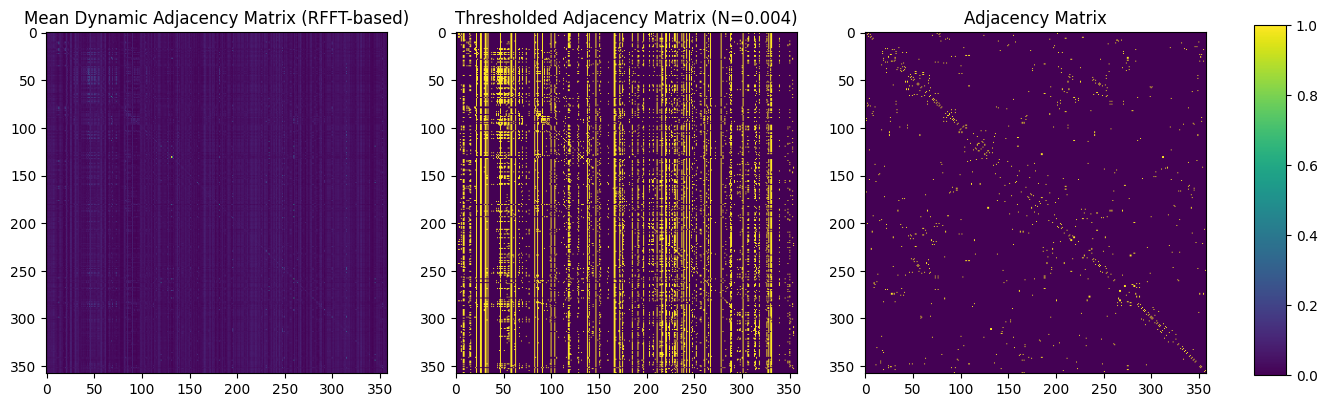

In [158]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Пороговое значение
N = 0.004

# Усредненная матрица
mean_adj = adj_matrix.mean(dim=0).detach().cpu().numpy()

# Бинаризуем: если значение больше N, ставим 1, иначе 0
binary_adj = (mean_adj > N).astype(np.float32)
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Первый график - усредненная матрица
im1 = axes[0].imshow(mean_adj, cmap='viridis')
axes[0].set_title("Mean Dynamic Adjacency Matrix (RFFT-based)")

# Второй график - бинаризированная матрица
im2 = axes[1].imshow(binary_adj, cmap='viridis')
axes[1].set_title(f"Thresholded Adjacency Matrix (N={N})")

# Второй график - конкретная матрица adj
im3 = axes[2].imshow(adj.detach().cpu().numpy(), cmap='viridis')
axes[2].set_title("Adjacency Matrix")

# Общий colorbar
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.15, 0.02, 0.7])
fig.colorbar(im3, cax=cbar_ax)  # Используем im1, так как он имеет плавающие значения

plt.show()


### Маскирование данных после обучения

В теории, это должно помочь оценить, какие признаки дали свой вклад, если они были :)

In [ ]:
# Перевод модели в режим тестирования
writer = SummaryWriter(log_dir=f"runs/T-GCN/removed_channel1 test/")
model.eval()

# Подсчёт метрик для всех батчей
test_loss, test_mae, test_rmse, test_mape = 0.0, 0.0, 0.0, 0.0
total_batches = len(test_loader)

# Пройдем все батчи и вычислим метрики
with torch.no_grad():
    for batch_idx, (history_data, target) in enumerate(test_loader):
        history_data, target = history_data.to(device), target.to(device)

        # Прогноз
        output = model(history_data, removed_channel=1).squeeze(-1)  # removed_channel=1, чтобы исключить канал N=1
        
        # Вычисление потерь и метрик
        loss = criterion(output, target)
        mae, rmse, mape = compute_metrics(output, target)

        # Добавляем в общие метрики
        test_loss += loss.item() * history_data.size(0)
        test_mae += mae
        test_rmse += rmse
        test_mape += mape

        # Запись метрик в TensorBoard для текущего батча
        writer.add_scalar("Loss/Test", loss.item(), batch_idx + 1)
        writer.add_scalar("MAE/Test", mae, batch_idx + 1)
        writer.add_scalar("RMSE/Test", rmse, batch_idx + 1)
        writer.add_scalar("MAPE/Test", mape, batch_idx + 1)

# Средние метрики по всем батчам
test_loss /= len(test_loader.dataset)
test_mae /= total_batches
test_rmse /= total_batches
test_mape /= total_batches

# Запись средней метрики в TensorBoard
writer.add_scalar("Loss/Test_Avg", test_loss, 0)
writer.add_scalar("MAE/Test_Avg", test_mae, 0)
writer.add_scalar("RMSE/Test_Avg", test_rmse, 0)
writer.add_scalar("MAPE/Test_Avg", test_mape, 0)

# Закрытие TensorBoard writer
writer.close()

# Вывод финальных результатов
print(f"Test Loss: {test_loss:.4f}, Test MAE: {test_mae:.4f}, Test RMSE: {test_rmse:.4f}, Test MAPE: {test_mape:.4f}")